In [29]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
import json
from datasets import Dataset
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [30]:
df = pd.read_parquet('data/1.cryptonews.parquet')
df.drop(columns=['news_url', 'image_url', 'type', 'tickers', 'topics', 'sentiment'], inplace=True)
print(df.shape)
df.head()

(159486, 4)


,title,text,source_name,date
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,"Fri, 01 Jan 2021 19:20:00 -0500"
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,"Fri, 01 Jan 2021 15:31:35 -0500"
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,"Fri, 01 Jan 2021 14:15:02 -0500"
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,"Fri, 01 Jan 2021 13:52:00 -0500"
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,"Fri, 01 Jan 2021 13:00:00 -0500"


In [31]:
# Filter out news without bitcoin mentions

df['with_bitcoin'] = df['title'].str.contains('bitcoin', case=False) | df['text'].str.contains('bitcoin', case=False) | df['title'].str.contains('btc', case=False) | df['text'].str.contains('btc', case=False)
print(df['with_bitcoin'].value_counts())

df = df[df['with_bitcoin'] == True]
df.drop(columns=['with_bitcoin'], inplace=True)

with_bitcoin
True     158414
False      1072
Name: count, dtype: int64


In [32]:
# Filter out news sources with less than 300 articles all-time

source_counts = df['source_name'].value_counts()
print(source_counts)

df = df[df['source_name'].isin(source_counts[source_counts > 300].index)]

source_name
Cointelegraph             9582
Coingape                  7148
CoinPedia                 6936
UToday                    6781
The Currency Analytics    6691
                          ... 
Coinradar                    4
Blockgeeks                   3
The Dog of Wall Street       2
InvestorPlace                1
Coindoo                      1
Name: count, Length: 97, dtype: int64


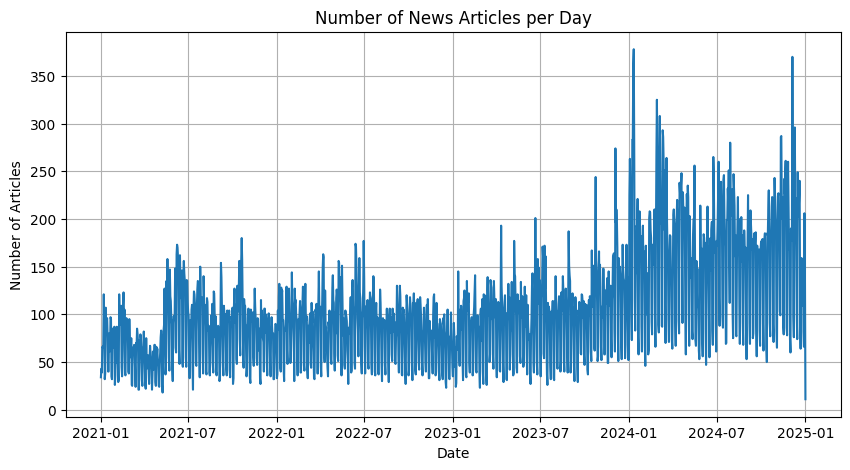

In [33]:
# Format the date column
df['date'] = pd.to_datetime(df['date'], format="%a, %d %b %Y %H:%M:%S %z", utc=True)

# Plot the number of news articles per day
news_per_day = df['date'].dt.date.value_counts().sort_index()

plt.figure(figsize=(10, 5))
news_per_day.plot(kind='line')
plt.title('Number of News Articles per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

In [34]:
df.head()

,title,text,source_name,date
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00


In [35]:
# Testing sentiment analysis
# Fine-tuned version of TinyLlama
# The dataset used for training is Crypto News+ on Kaggle
# poor performance, not using

dataset = Dataset.from_pandas(df)
dataset = dataset.select(range(30))

MODEL_NAME = "curiousily/tiny-crypto-sentiment-analysis"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
  MODEL_NAME,
  device_map="auto",
  torch_dtype=torch.float16
)

pipe = pipeline(
  task="text-generation",
  model=model,
  tokenizer=tokenizer,
  max_new_tokens=16,
  return_full_text=False,
)

def generate_prediction(batch):
  prompts = [
    f"""
    ### Title:
    {title}
    ### Text:
    {text}
    ### Prediction:
    """.strip()
    for title, text in zip(batch['title'], batch['text'])
  ]
  outputs = pipe(prompts)
  predictions = [output[0]["generated_text"].strip() for output in outputs]
  return {"prediction": predictions}

dataset = dataset.map(generate_prediction, batched=True, batch_size=8)
print(dataset)

temp_df = dataset.to_pandas()
temp_df.head()

Device set to use cuda:0


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Dataset({
    features: ['title', 'text', 'source_name', 'date', '__index_level_0__', 'prediction'],
    num_rows: 30
})


,title,text,source_name,date,__index_level_0__,prediction
0,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00,0,subject: bitcoin\nsentiment: neutral
1,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00,1,subject: bitcoin\nsentiment: neutral
2,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00,2,subject: bitcoin\nsentiment: neutral
3,Bitcoin hits all-time high against gold as hav...,"BTC has hit another milestone, this time again...",Cointelegraph,2021-01-01 18:52:00+00:00,3,subject: bitcoin\nsentiment: neutral
4,"The Last Time This Indicator Flashed, Bitcoin ...",Bitcoin has been facing some turbulence as of ...,Bitcoinist,2021-01-01 18:00:00+00:00,4,subject: bitcoin\nsentiment: positive


In [36]:
# No labelled data
# Many pretrained models use outdated underlying models, leading to poor performance
# Not many models are fine-tuned for crypto news (more on social media)

In [37]:
df['date'].dt.year.value_counts()

date
2024    59994
2023    35436
2022    31147
2021    28788
2025       11
Name: count, dtype: int64

In [38]:
df.shape

(155376, 4)

In [39]:
df.to_parquet('data/2.cryptonews_processed.parquet')